# Benchmark ESNs using Spoken Arabic Digit Dataset

Dataset url: https://archive.ics.uci.edu/ml/datasets/Spoken+Arabic+Digit

I have written many functions to facilitate the execution of the code. Each function has detailed documentation.

Installed required modules in Azure. Note that Oger install file must be uploaded to AZURE manually before running these commands.

(For some reason as of 24.08.2017 Azure no longer accepts the "!pip install Oger-1.2.tar.gz". This is probably due to some update.)

If NOT running in Azure ignore this step!

In [1]:
!pip install mdp
!pip install Oger-1.2.tar.gz

    100% |################################| 368kB 2.1MB/s ta 0:00:01
Processing ./Oger-1.1.2_azure_BETA.tar.gz
  Running setup.py bdist_wheel for Oger ... - done
  Stored in directory: /home/nbuser/.cache/pip/wheels/e7/4c/ab/1e62b0065991eb8e45fa5e228659261e8d7b5826f27054e4a6
Successfully built Oger


In [2]:
import Oger
import mdp
import numpy as np

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

/home/nbuser/anaconda2_410/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/nbuser/anaconda2_410/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/nbuser/anaconda2_410/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be rem

Helper function to load the files of the dataset.

In [3]:
def _load_file(filename):
    """
    Loads a file from the 'Spoken Arabic Digit Data Set'.
    (https://archive.ics.uci.edu/ml/datasets/Spoken+Arabic+Digit)
    
    The format of these files is specific. According to the documentation lines 
    are organized into blocks, which are a set of 4-93 lines separated by blank 
    lines and corresponds to a single speech utterance of a spoken Arabic 
    digit with 4-93 frames. Each spoken digit is a set of consecutive blocks.
    
    Since blocks are 4-93 frames, the blocks that have less frames than the
    maximum (93) will be padded with zeros. Each block is transformed into a
    2D numpy array and added to the blocks list. The blocks list is returned.
    
    Parameters
    ----------
    filename : string
            the path and name of the file to load
    
    Returns
    -------
    blocks : list of 2D numpy arrays
            the list with all the blocks transformed into 2D numpy arrays
                padded with zeros, if required
    """
    empty_lines = 0
    blocks = []
    with open(filename) as loaded_file:
        for line in loaded_file:
            if not line.strip():
                # if first empty line start a new block
                if empty_lines == 0:
                    block = np.zeros([93, 13])
                    i = 0
                # save current block and start a new one
                else:
                    blocks.append(block)
                    block = np.zeros([93, 13])
                    i = 0
                    
                empty_lines += 1
                
            else:
                block[i, :] = np.array(line.replace('\n', '').split(' '), dtype='|S10').astype(np.float)
                i += 1           
        else:
            # add last block
            blocks.append(block)
            
    return blocks

In [4]:
def _transform_X_matrix(X, per_coefficients=True):
    """
    Transforms a list of 2D numpy arrays into a 2D numpy array by reshaping the
    2D numpy arrays of the list into a 1D arrays.
    
    Parameters
    ----------
    X : list of 2D numpy arrays
            the list to be transformed
            
    per_coefficients : boolean
            parameter than controls the way the reshaping happens
                True : the created 1D arrays are the sequence of the chance of
                    the 13 Mel Frequency Cepstral Coefficients (MFCCs) over the
                    time of digit utterance
                False : the created 1D arrays are the sequence of the frames of
                    the digit utterance
    
    Returns
    -------
    X_reshaped : 2D numpy array
            2D array where each line is a flattened block
    """
    X_reshaped = np.zeros([len(X), len(X[0][0,:])*len(X[0][:,0])])
    if per_coefficients:
        for i, block in enumerate(X):
            X_reshaped[i, :] = np.reshape(block.T, 
                                    (len(X[0][0,:])*len(X[0][:,0]))) # 13*93
    else:
        for i, block in enumerate(X):
            X_reshaped[i, :] = np.reshape(block, 
                                    (len(X[0][0,:])*len(X[0][:,0])))
            
    return X_reshaped

In [5]:
def correctly_format_data(X_train, y_train):
    """
    Correctly formats and returns the data required for training by Oger.
    
    Parameters
    ----------
    X_train : the features matrix. (numpy 2d array)
    
    y_train : target values (class labels). (numpy 1d array)
    """
    x_correct = []
    for row in X_train:
        x_correct.append(row[np.newaxis, :])
    y_correct = []
    if y_train.ndim == 1:
        for elem in y_train:
            y_correct.append(np.array([elem])[:, np.newaxis])
    else:
        for elem in y_train:
            y_correct.append(np.array([elem]))#[:, np.newaxis])
    data = [[], zip(x_correct, y_correct)]
    
    return data

In [6]:
def select_classification_of_digits(y_predict):
    """
    Takes the classifications of every network and selects the winner.
    
    Parameters
    ----------
    y_predict : 2D numpy array
            the unthresholded predictions of the networks
            
    Returns
    -------
    1D numpy array of the best matching classification for every test sample
    """
    return np.argmax(y_predict, axis=1)

In [7]:
def calculate_accuracy(y_predict, y_test):
    """
    TODO: write
    """
    if y_predict.ndim == y_test.ndim:
        accuracy = float(np.sum(y_predict == y_test)) / len(y_test)
    elif y_predict.ndim > y_test.ndim:
        accuracy = float(np.sum(y_predict == y_test[:, np.newaxis])
                                                                ) / len(y_test)
    elif y_predict.ndim < y_test.ndim: # TODO: replace with else?
        accuracy = float(np.sum(y_predict[:, np.newaxis] == y_test)
                                                                ) / len(y_test)
    return accuracy

Load the speech blocks contained in the train and test files.

In [9]:
train_blocks = _load_file('Train_Arabic_Digit.txt')
test_blocks = _load_file('Test_Arabic_Digit.txt')

Create the corresponding classes for each block. (see Dataset repository for more details)

In [10]:
y_train = np.zeros([6600])
for digit, i in enumerate(range(0, 6600, 660)):
    y_train[i: i + 660] = digit
    
y_test = np.zeros([2200])
for digit, i in enumerate(range(0, 2200, 220)):
    y_test[i: i + 220] = digit

Transform the blocks into proper 1D arrays (using a helper function) to be used for machine learning. False flag means that the arrays are the sequence of the frames of the digit utterance. If set true then it would be the the sequence of the chance of the 13 Mel Frequency Cepstral Coefficients (MFCCs) over the time of digit utterance.

In [11]:
X_train = _transform_X_matrix(train_blocks, False)
X_test = _transform_X_matrix(test_blocks, False)

I will use the same reservoir but a seperate output for every digits as described in the literature. Each output will be trained using binary data for the corresponding digit. For this reason the X_train data must be modified for every output. Example: output for digit 0 will be trained with data where digit 0 gives output 1 and all other digits -1.

In [12]:
# create binary data for each digit for each flow
y_train_multiple = (-1) * np.ones([len(y_train), 10])
y_test_multiple = (-1) * np.ones([len(y_test), 10])
for i in range(10):
    for j, digit in enumerate(y_train):
        if digit == i:
            y_train_multiple[j, i] = 1
            
    for j, digit in enumerate(y_test):
        if digit == i:
            y_test_multiple[j, i] = 1

# Example run

In [13]:
# create reservoir
reservoir = Oger.nodes.ReservoirNode(len(X_train[0, :]), 100, 
             input_scaling=0.5)

# create a flow per digit
flows = []
for i in range(10):
    readout = Oger.nodes.RidgeRegressionNode(10e-9, verbose=True)
    flow = mdp.Flow([reservoir, readout], verbose=0)
    flows.append(flow)

In [14]:
# train each flow to corresponding digit
for i, flow in enumerate(flows):
    data = correctly_format_data(X_train, y_train_multiple[:, i])
    flow.train(data)

In [15]:
# predict digit using all flows
y_predict_mult = np.zeros(shape=y_test_multiple.shape)
for i, flow in enumerate(flows):
    y_predict = flow(X_test)
    y_predict_mult[:, i] = y_predict[:, 0]

In [16]:
#y_test = y_test[:, np.newaxis]

y_predict_single = select_classification_of_digits(y_predict_mult)
accuracy = calculate_accuracy(y_predict_single, y_test)

print "Accuracy: ", accuracy
print "WER:", (1 - accuracy)

Accuracy:  0.881363636364
WER: 0.118636363636


# Plot the confusion matrix

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmax=1.)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tick_params(which = 'both', direction = 'out')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                    size = 8)
        else:
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")    

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()#savefig('test.png')

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict_single)
np.set_printoptions(precision=2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Confusion matrix, without normalization
[[142   5   2   1   7   7  11  23   0  22]
 [  0 214   2   1   0   0   0   2   1   0]
 [  0   7 197   1   4   1   1   1   1   7]
 [  2   3   3 203   3   0   0   0   6   0]
 [  2   0   0   0 215   1   0   2   0   0]
 [  6   6   0   2  11 182   9   1   2   1]
 [  9   1   1   2   0   5 197   3   1   1]
 [  5   2   3   0  13   0   2 183   8   4]
 [  0   3   0   9   2   2   0   1 203   0]
 [  0   0  10   0   1   0   0   6   0 203]]


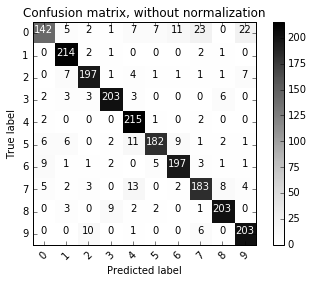

In [55]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [72]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

Normalized confusion matrix
[[ 0.65  0.02  0.01  0.    0.03  0.03  0.05  0.1   0.    0.1 ]
 [ 0.    0.97  0.01  0.    0.    0.    0.    0.01  0.    0.  ]
 [ 0.    0.03  0.9   0.    0.02  0.    0.    0.    0.    0.03]
 [ 0.01  0.01  0.01  0.92  0.01  0.    0.    0.    0.03  0.  ]
 [ 0.01  0.    0.    0.    0.98  0.    0.    0.01  0.    0.  ]
 [ 0.03  0.03  0.    0.01  0.05  0.83  0.04  0.    0.01  0.  ]
 [ 0.04  0.    0.    0.01  0.    0.02  0.9   0.01  0.    0.  ]
 [ 0.02  0.01  0.01  0.    0.06  0.    0.01  0.83  0.04  0.02]
 [ 0.    0.01  0.    0.04  0.01  0.01  0.    0.    0.92  0.  ]
 [ 0.    0.    0.05  0.    0.    0.    0.    0.03  0.    0.92]]


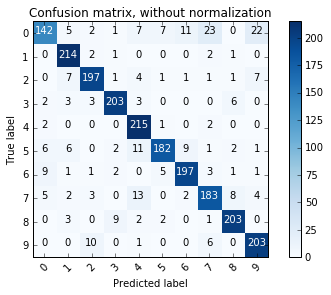

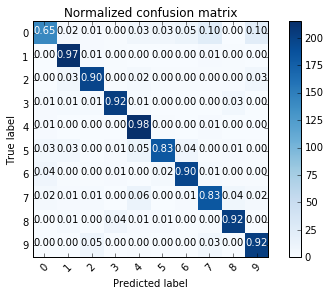

In [21]:
plt.show()

# Run the benchmark for the models

CAUTION: do NOT enable washout because it makes the results VERY bad!

In [12]:
# set the required dictionaries

string_names_dict_short = {
    0: 'ESN',
    1: 'DLR',
    2: 'DLRB',
    3: 'SCR',
    4: 'CRJ',
    5: 'FF-ESN',
    6: 'SORM',
    7: 'CyclicSORM'
}

string_names_dict_full = {
    0: 'original ESN',
    1: 'DelayLineReservoir',
    2: 'DelayLineReservoirWithFeedback',
    3: 'SimpleCycleReservoir',
    4: 'CycleReservoirWithJumps',
    5: 'FeedForwardESN',
    6: 'SparseAndOrthogonalMatrices',
    7: 'CyclicSparseAndOrthogonalMatrices'
}

nodes_dict = {
    0: Oger.nodes.ReservoirNode,
    1: Oger.nodes.DelayLineReservoirNode,
    2: Oger.nodes.DelayLineWithFeedbackReservoirNode,
    3: Oger.nodes.SimpleCycleReservoirNode,
    4: Oger.nodes.CycleReservoirWithJumpsNode,
    5: Oger.nodes.FeedForwardESNReservoir,
    6: Oger.nodes.SparseAndOrthogonalMatricesReservoir,
    7: Oger.nodes.CyclicSORMsReservoir
}

In [13]:
# set the parameters

input_scaling = 0.5 # best parameter for most models found through trial-error
bias_scaling = 0.0 # best parameter for most models found through trial-error
number_of_neurons = 100 # for the test run and the grid-search
number_of_neurons_list = [50, 100, 150, 200] # for the evaluation
number_of_runs = 10 # number of random runs per model

In [14]:
# test the models

model_accuracy = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])
WER = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])

count = 0
max_count = model_accuracy.shape[0] * model_accuracy.shape[1] * model_accuracy.shape[2]

mdp.utils.progressinfo(enumerate(number_of_neurons_list), style='timer', length=len(number_of_neurons_list))

# run the test for every reservoir
for i, reservoir_size in mdp.utils.progressinfo(enumerate(number_of_neurons_list), style='timer', length=len(number_of_neurons_list)):
    for key, reservoir_node in nodes_dict.iteritems():
        for j in range(number_of_runs):       
            # create reservoir
            reservoir = reservoir_node(input_dim=len(X_train[0, :]), output_dim=reservoir_size, 
                                       input_scaling=input_scaling, bias_scaling=bias_scaling)

            # create a flow per digit
            flows = []
            for k in range(10):
                readout = Oger.nodes.RidgeRegressionNode(10e-9, verbose=True)
                flow = mdp.Flow([reservoir, readout], verbose=0)
                flows.append(flow)
                
            # train each flow to corresponding digit
            for k, flow in enumerate(flows):
                data = correctly_format_data(X_train, y_train_multiple[:, k])
                flow.train(data)
                
            # predict digit using all flows
            y_predict_mult = np.zeros(shape=y_test_multiple.shape)
            for k, flow in enumerate(flows):
                y_predict = flow(X_test)
                y_predict_mult[:, k] = y_predict[:, 0]
                
            # calculate accuracy
            y_predict_single = select_classification_of_digits(y_predict_mult)
            accuracy = calculate_accuracy(y_predict_single, y_test)
            
            # save result
            model_accuracy[i, key, j] = accuracy
            WER[i, key, j] = (1 - accuracy)
            
            count += 1
            print "Progress: ", str(float(count) / max_count)

  0% ? - ?Progress:  0.00625
Progress:  0.0125
Progress:  0.01875
Progress:  0.025
Progress:  0.03125
Progress:  0.0375
Progress:  0.04375
Progress:  0.05
Progress:  0.05625
Progress:  0.0625
Progress:  0.06875
Progress:  0.075
Progress:  0.08125
Progress:  0.0875
Progress:  0.09375
Progress:  0.1
Progress:  0.10625
Progress:  0.1125
Progress:  0.11875
Progress:  0.125
Progress:  0.13125
Progress:  0.1375
Progress:  0.14375
Progress:  0.15
Progress:  0.15625
Progress:  0.1625
Progress:  0.16875
Progress:  0.175
Progress:  0.18125
Progress:  0.1875
Progress:  0.19375
Progress:  0.2
Progress:  0.20625
Progress:  0.2125
Progress:  0.21875
Progress:  0.225
Progress:  0.23125
Progress:  0.2375
Progress:  0.24375
Progress:  0.25
Progress:  0.25625
Progress:  0.2625
Progress:  0.26875
Progress:  0.275
Progress:  0.28125
Progress:  0.2875
Progress:  0.29375
Progress:  0.3
Progress:  0.30625
Progress:  0.3125
Progress:  0.31875
Progress:  0.325
Progress:  0.33125
Progress:  0.3375
Progress:  0.

In [15]:
# save the errors for later processing
np.save("speech_recognition_accuracies", model_accuracy)
np.save("speech_recognition_WER", WER)